## Neural Networks with Keras

### Deep Neural Network exercises

Please make sure you install the following packages on your machine (No installation needed when you work on Google Colab) 

##### Requires the latest pip
    
    $ pip install --upgrade pip
    

##### Current stable release for CPU and GF
    $ pip install tensorflow


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "NN_deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

[-5, 5, -1.2, 1.2]

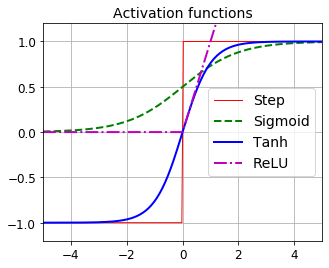

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)


z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

### import tensorflow and keras

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
tf.__version__

'2.3.0-dev20200514'

In [5]:
keras.__version__

'2.2.4-tf'

## Exercise 1: Predicting Wine Types: Red or White? (Binary Classification Problem)

We will use the wine quality data set that you can find in the wine quality data set from the UCI Machine Learning Repository. In general, you perform deep learning on a lot bigger data sets than the ones we will use in this exercise. 

### Wine dataset attributes (features)

The data consists of two datasets that are related to red and white variants of the Portuguese “Vinho Verde” wine. As stated in the description, you’ll only find physicochemical and sensory variables included in this data set. The data description file lists the 12 variables that are included in the data, but for those who, like me, aren’t really chemistry experts either, here’s a short description of each variable:

1. Fixed acidity: acids are major wine properties and contribute greatly to the wine’s taste. Usually, the total acidity is divided into two groups: the volatile acids and the nonvolatile or fixed acids. Among the fixed acids that you can find in wines are the following: tartaric, malic, citric, and succinic. This variable is expressed in g(tartaricacid)/dm3 in the data sets.

2. Volatile acidity: the volatile acidity is basically the process of wine turning into vinegar. In the U.S, the legal limits of Volatile Acidity are 1.2 g/L for red table wine and 1.1 g/L for white table wine. In these data sets, the volatile acidity is expressed in g(aceticacid)/dm3.

3. Citric acid is one of the fixed acids that you’ll find in wines. It’s expressed in g/dm3 in the two data sets.

4. Residual sugar typically refers to the sugar remaining after fermentation stops, or is stopped. It’s expressed in g/dm3 in the red and white data.

5. Chlorides can be a significant contributor to saltiness in wine. Here, you’ll see that it’s expressed in g(sodiumchloride)/dm3.

6. Free sulfur dioxide: the part of the sulfur dioxide that is added to a wine and that is lost into it is said to be bound, while the active part is said to be free. The winemaker will always try to get the highest proportion of free sulfur to bind. This variable is expressed in mg/dm3 in the data.

7. Total sulfur dioxide is the sum of the bound and the free sulfur dioxide (SO2). Here, it’s expressed in mg/dm3.  There are legal limits for sulfur levels in wines: in the EU, red wines can only have 160mg/L, while white and rose wines can have about 210mg/L. Sweet wines are allowed to have 400mg/L. For the US, the legal limits are set at 350mg/L, and for Australia, this is 250mg/L.

8. Density is generally used as a measure of the conversion of sugar to alcohol. Here, it’s expressed in g/cm3.

9. pH or the potential of hydrogen is a numeric scale to specify the acidity or basicity the wine. As you might know, solutions with a pH less than 7 are acidic, while solutions with a pH greater than 7 are basic. With a pH of 7, pure water is neutral. Most wines have a pH between 2.9 and 3.9 and are therefore acidic.

10. Sulfates are to wine as gluten is to food. You might already know sulfites from the headaches that they can cause. They are a regular part of the winemaking around the world and are considered necessary. In this case, they are expressed in g(potassiumsulphate)/dm3.

11. Alcohol: wine is an alcoholic beverage, and as you know, the percentage of alcohol can vary from wine to wine. It shouldn’t be surprised that this variable is included in the data sets, where it’s expressed in % vol.

12. Quality: wine experts graded the wine quality between 0 (very bad) and 10 (very excellent). The eventual number is the median of at least three evaluations made by those same wine experts.

### Data Loading

In [6]:
# Read in white wine data 
white = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
                    sep=';')

# Read in red wine data 
red = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", 
                  sep=';')

### Quick view of data

In [7]:
# Print info on white wine
print(white.info())

# Print info on red wine
print(red.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null fl

### More information about datasets

- Double check whether the data contains all the variables that the data description file of the UCI Machine Learning Repository provides. 

- Besides the number of variables, also check the quality of the import: are the data types correct? Did all the rows come through? Are there any null values that you should take into account when you’re cleaning up the data?

Some tips:

- A brief recap of all these pandas functions: you see that head(), tail() and sample() are fantastic because they provide you with a quick way of inspecting your data without any hassle.

- Next, describe() offers some summary statistics about your data that can help you to assess your data quality. You see that some of the variables have a lot of difference in their min and max values. This is something that you’ll deal with later, but at this point, it’s just imperative to be aware of this.

- Lastly, you have double checked the presence of null values in red with the help of isnull(). This is a function that always can come in handy when you’re still in doubt after having read the results of info().

In [8]:
# First rows of `red` 
red.head()

# Last rows of `white`
white.tail()

# Take a sample of 5 rows of `red`
red.sample(5)

# Describe `white`
white.describe()

# Double check for null values in `red`
pd.isnull(red)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False


### Data visualization

The alcohol levels between the red and white wine are mostly the same: they have around 9% of alcohol. Of course, there are also a considerable amount of observations that have 10% or 11% of alcohol percentage.

#### Histograms

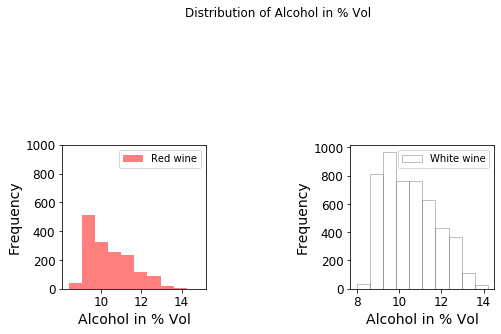

In [9]:
fig, ax = plt.subplots(1, 2)

ax[0].hist(red.alcohol, 10, facecolor='red', alpha=0.5, label="Red wine")
ax[1].hist(white.alcohol, 10, facecolor='white', ec="black", lw=0.5, alpha=0.5, label="White wine")

fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=1)

ax[0].set_ylim([0, 1000])
ax[0].set_xlabel("Alcohol in % Vol")
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("Alcohol in % Vol")
ax[1].set_ylabel("Frequency")

ax[0].legend(loc='best')
ax[1].legend(loc='best')

fig.suptitle("Distribution of Alcohol in % Vol")

plt.show()

#### Histograms computed based on alcohol

In [10]:
print(np.histogram(red.alcohol, bins=[7,8,9,10,11,12,13,14,15]))
print(np.histogram(white.alcohol, bins=[7,8,9,10,11,12,13,14,15]))

(array([  0,   7, 673, 452, 305, 133,  21,   8]), array([ 7,  8,  9, 10, 11, 12, 13, 14, 15]))
(array([   0,  317, 1606, 1256,  906,  675,  131,    7]), array([ 7,  8,  9, 10, 11, 12, 13, 14, 15]))


#### Scatter graphs based on sulphates

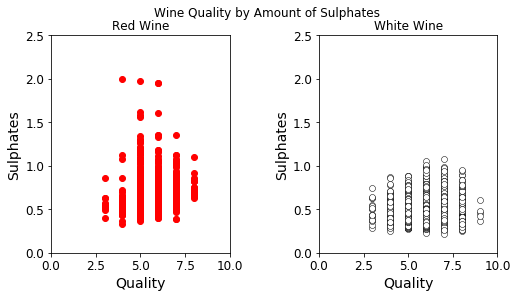

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].scatter(red['quality'], red["sulphates"], color="red")
ax[1].scatter(white['quality'], white['sulphates'], color="white", edgecolors="black", lw=0.5)

ax[0].set_title("Red Wine")
ax[1].set_title("White Wine")
ax[0].set_xlabel("Quality")
ax[1].set_xlabel("Quality")
ax[0].set_ylabel("Sulphates")
ax[1].set_ylabel("Sulphates")
ax[0].set_xlim([0,10])
ax[1].set_xlim([0,10])
ax[0].set_ylim([0,2.5])
ax[1].set_ylim([0,2.5])

fig.subplots_adjust(wspace=0.5)
fig.suptitle("Wine Quality by Amount of Sulphates")

plt.show()

#### Scatter graphs based on acidity

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

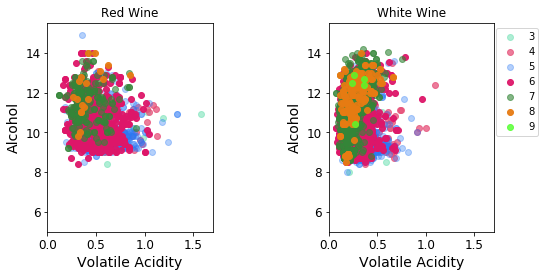

In [12]:
np.random.seed(570)

redlabels = np.unique(red['quality'])
whitelabels = np.unique(white['quality'])

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

redcolors = np.random.rand(6,4)
whitecolors = np.append(redcolors, np.random.rand(1,4), axis=0)

for i in range(len(redcolors)):
    redy = red['alcohol'][red.quality == redlabels[i]]
    redx = red['volatile acidity'][red.quality == redlabels[i]]
    ax[0].scatter(redx, redy, c=redcolors[i])
for i in range(len(whitecolors)):
    whitey = white['alcohol'][white.quality == whitelabels[i]]
    whitex = white['volatile acidity'][white.quality == whitelabels[i]]
    ax[1].scatter(whitex, whitey, c=whitecolors[i])
    
ax[0].set_title("Red Wine")
ax[1].set_title("White Wine")
ax[0].set_xlim([0,1.7])
ax[1].set_xlim([0,1.7])
ax[0].set_ylim([5,15.5])
ax[1].set_ylim([5,15.5])
ax[0].set_xlabel("Volatile Acidity")
ax[0].set_ylabel("Alcohol")
ax[1].set_xlabel("Volatile Acidity")
ax[1].set_ylabel("Alcohol") 
#ax[0].legend(redlabels, loc='best', bbox_to_anchor=(1.3, 1))
ax[1].legend(whitelabels, loc='best', bbox_to_anchor=(1.3, 1))
#fig.suptitle("Alcohol - Volatile Acidity")
fig.subplots_adjust(top=0.85, wspace=0.7)

plt.show()

### Data preprocessing for assigning a class label: red is set to 1 and white is set to 0

In [13]:
# Add `type` column to `red` with value 1
red['type'] = 1

# Add `type` column to `white` with value 0
white['type'] = 0

# Append `white` to `red`
wines = red.append(white, ignore_index=True)

### Correlation matrix

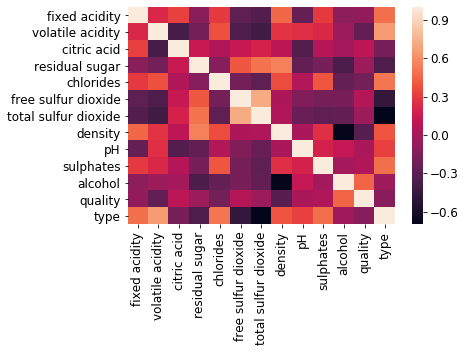

In [14]:
import seaborn as sns

corr = wines.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

### Training and testing datasets

- X: 11 attributes
    
- y: class label, either 0 (white wine) or 1 (red wine)

Imbalanced data typically refers to a problem with classification problems where the classes are not represented equally.Most classification data sets do not have exactly equal number of instances in each class, but a small difference often does not matter. You thus need to make sure that all two classes of wine are present in the training model. What’s more, the amount of instances of all two wine types needs to be more or less equal so that you do not favour one or the other class in your predictions.

In this example, there seems to be an imbalance, but you will go with this for the moment. Afterwards, you can evaluate the model and if it underperforms, you can resort to undersampling or oversampling to cover up the difference in observations.

In [15]:
# Import `train_test_split` from `sklearn.model_selection`
from sklearn.model_selection import train_test_split

# Specify the data 
X=wines.iloc[:, 0:11]

print(X[:5])

X = X.values

# Specify the target labels and flatten the array
y= np.ravel(wines.type)

# first 5 row data for X (attributes) and y (class label)
print(X[:10][:5])
print(y[:5])

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4  
[[7.400e

### Standardize the data (scaling)

Standardization is a way to deal with these values that lie so far apart. The scikit-learn package offers you a great and quick way of getting your data standardized: import the StandardScaler module from sklearn.preprocessing and scale train and test data.

In [16]:
# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

### Model construction

#### Contruct a neural network

A quick way to get started is to use the Keras Sequential model: it’s a linear stack of layers. You can easily create the model by passing a list of layer instances to the constructor.

Next, it’s best to think back about the structure of the multi-layer perceptron as you might have read about it in the beginning of this tutorial: you have an input layer, some hidden layers and an output layer. When you’re making your model, it’s therefore important to take into account that your first layer needs to make the input shape clear. The model needs to know what input shape to expect and that’s why you’ll always find the input_shape, input_dim, input_length, or batch_size arguments in the documentation of the layers and in practical examples of those layers.

In this example, we will have to use a Dense layer, which is a fully connected layer. Dense layers implement the following operation: output = activation(dot(input, kernel) + bias). Note that without the activation function, your Dense layer would consist only of two linear operations: a dot product and an addition.

In the first layer, the activation argument takes the value relu. The input_shape is the input of the operation: the model takes as input arrays of shape (11,), or (*, 11). Lastly, the first layer has 12 as a first value for the units argument of Dense(), which is the dimensionality of the output space and which are actually 12 hidden units. This means that the model will output arrays of shape (*, 12): this is is the dimensionality of the output space.

Note that we don’t include any bias in the example below. 

The intermediate layer also uses the relu activation function. The output of this layer will be arrays of shape (*,8).

We will end the network with a Dense layer of size 1. The final layer will use a sigmoid activation function so that your output is actually a probability; This means that this will result in a score between 0 and 1, indicating how likely the sample is to have the target “1”, or how likely the wine is to be red.

In [17]:
# Initialize the constructor
model = keras.models.Sequential()

# Add the first hidden layer and specify the shape of input layer
model.add(keras.layers.Dense(12, activation='relu', input_shape=(11,)))

# Add the second hidden layer
model.add(keras.layers.Dense(8, activation='relu'))

# Add an output layer 
model.add(keras.layers.Dense(1, activation='sigmoid'))

#### Construct a neural network in another way

- This will the exactly same model as the model above

In [18]:
# construct a model

model = keras.models.Sequential([
    keras.layers.Dense(12, activation='relu', input_shape=(11,)),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

### Discussions about the number of units in hidden layers

In this example, we have 12 hidden units for the first layer of the model: this is is the dimensionality of the output space. In other words, we set the amount of freedom that we allow the network to have when it’s learning representations. 

If we would allow more hidden units, the network will be able to learn more complex representations but it will also be a more expensive operations that can be prone to overfitting.

Remember that overfitting occurs when the model is too complex: it will describe random error or noise and not the underlying relationship that it needs to describe. In other words, the training data is modeled too well!

Note that when we don’t have that much training data available, you should prefer to use a small network with very few hidden layers (typically only one, like in the example above).

### Information about the model

- use the attribute, output_shape 

or 

- summary() function

In [19]:
# Model output shape
model.output_shape

# Model summary
model.summary()

# Model config
model.get_config()

# List all weight tensors 
model.get_weights()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                144       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


[array([[-0.39983654,  0.30398518,  0.45890093, -0.4229054 ,  0.33702725,
         -0.17397156, -0.30357748, -0.43687704, -0.27240247,  0.4304753 ,
         -0.07953107, -0.13161081],
        [ 0.4749627 , -0.1496689 , -0.28396615, -0.06752884,  0.18867481,
         -0.15661791,  0.45676684, -0.12443179,  0.02395219, -0.45031703,
          0.05094677,  0.48518425],
        [-0.41752094, -0.24980876, -0.09157127,  0.15591598,  0.4592139 ,
          0.16351783,  0.04276687,  0.47056353,  0.22230387, -0.5049877 ,
          0.30362427, -0.35358316],
        [ 0.10218257, -0.46100032, -0.00151414,  0.06371713,  0.24025154,
         -0.29815444,  0.47501165,  0.43193036,  0.15657502, -0.15560025,
          0.33064914,  0.326582  ],
        [ 0.20497525,  0.41765285, -0.14593536, -0.27488238,  0.29136604,
         -0.02672276, -0.2754777 , -0.40695882, -0.03645283, -0.01434183,
          0.29932678, -0.24402684],
        [ 0.2731533 , -0.1055724 ,  0.34578532,  0.14934915, -0.20411944,
      

### Plot the model archiecture

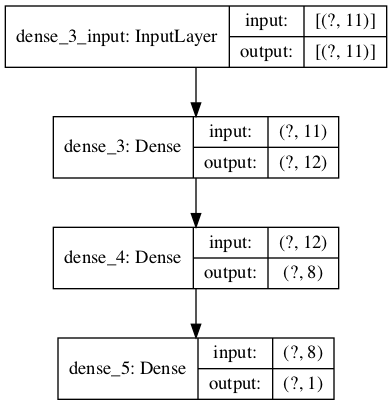

In [20]:
keras.utils.plot_model(model, "./images/wine_mnist_model.png", show_shapes=True)

### Compile the model and Fit the model to the data



The optimizer and the loss are two arguments that are required if you want to compile the model. In compiling, we configure the model with the adam optimizer and the binary_crossentropy loss function (cost function is logistic regression). Additionally, we can also monitor the accuracy during the training by passing ['accuracy'] to the metrics argument.

Some of the most popular optimization algorithms used are the Stochastic Gradient Descent (SGD), ADAM and RMSprop. Depending on whichever algorithm you choose, you’ll need to tune certain parameters, such as learning rate or momentum. 

The choice for a loss function depends on the task that we have at hand: for example, for a regression problem, we’ll usually use the Mean Squared Error (MSE). In this example, we will use binary_crossentropy for the binary classification problem of determining whether a wine is red or white (which means it is the cost function of logistic regression). Lastly, with multi-class classification, we make use of categorical_crossentropy.

After, we can train the model for a certain number of epochs (we can try it with epochs = 3, 10, 20, etc.) or iterations over all the samples in X_train and y_train, in batches of 1 sample. We can also specify the verbose argument. By setting it to 1, we indicate that we want to see progress bar logging.

In other words, we have to train the model for a specified number of epochs or exposures to the training dataset. An epoch is a single pass through the entire training set, followed by testing of the verification set. The batch size that we specify in the code above defines the number of samples that going to be propagated through the network. Also, by doing this, we optimize the efficiency because you make sure that you don’t load too many input patterns into memory at the same time.

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
model.fit(X_train, y_train,epochs=3, batch_size=1, verbose=1)

Epoch 1/3
4352/4352 [==============================] - 2s 484us/step - loss: 0.1008 - accuracy: 0.9706
Epoch 2/3
4352/4352 [==============================] - 2s 477us/step - loss: 0.0264 - accuracy: 0.9938
Epoch 3/3
4352/4352 [==============================] - 2s 474us/step - loss: 0.0226 - accuracy: 0.9949


### Properties of the model

The dir() function returns all properties and methods of the specified object, without the values. This function will return all the properties and methods, even built-in properties which are default for all object.

In [22]:
dir(model)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_attribute_sentinel',
 '_auto_track_sub_layers',
 '_autocast',
 '_base_model_initialized',
 '_build_graph_network_for_inferred_shape',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_check_call_args',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_collect_input_masks',
 '_compile_was_c

### Predict values

In [23]:
y_pred = model.predict_classes(X_test)

print(y_test[:5])
print(y_pred[:5])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[0 1 0 0 0]
[[0]
 [1]
 [0]
 [0]
 [0]]


### Evaluate Model

In this example, we will use evaluate() to do this. 

The score value returned by the function evaluate() is a list that holds the combination of the loss and the accuracy. In this case, you see that both seem very great, but in this case it’s good to remember that your data was somewhat imbalanced: you had more white wine than red wine observations. The accuracy might just be reflecting the class distribution of your data because it’ll just predict white because those observations are abundantly present!


In [24]:
score = model.evaluate(X_test, y_test,verbose=1)

print(score)

68/68 [==============================] - 0s 488us/step - loss: 0.0367 - accuracy: 0.9916
[0.03666511923074722, 0.9916083812713623]


### Other performance metrtics

- The confusion matrix, which is a breakdown of predictions into a table showing correct predictions and the types of incorrect predictions made. Ideally, you will only see numbers in the diagonal, which means that all your predictions were correct!

- Precision is a measure of a classifier’s exactness. The higher the precision, the more accurate the classifier.

- Recall is a measure of a classifier’s completeness. The higher the recall, the more cases the classifier covers.

- The F1 Score or F-score is a weighted average of precision and recall.

In [25]:
# Import the modules from `sklearn.metrics`
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

# Confusion matrix
cmatrix = confusion_matrix(y_test, y_pred)

print(cmatrix)

# precision
precision = precision_score(y_test, y_pred)

# Recall
recall = recall_score(y_test, y_pred)

# F1 score
f1 = f1_score(y_test,y_pred)

print('precision: {:.4f}\nrecall: {:.4f}\nf1 score: {:.4f}'.format(precision, recall, f1))

[[1579    9]
 [   9  548]]
precision: 0.9838
recall: 0.9838
f1 score: 0.9838


## Exercise 2: Predicting Wine Quality (Regression Problem)

### Preprocess the data

- X: 12 attributes
    
- y: wines.quality

In [26]:
# Isolate target labels
y = wines.quality

# Isolate data
X = wines.drop('quality', axis=1) 

print(X[:5])

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  type  
0      9.4     1  
1      9.8     1  
2      9.8     1  
3      9.8

### Standardized the data

In [27]:
# Scale the data with `StandardScaler`
X = StandardScaler().fit_transform(X)

### Modeling a neural network

In this example, we assume that quality is a continuous variable: the task is then a regression problem. 

The quality value exists on an arbitrary scale where the relative ordering between the different quality values is significant. In this scale, the quality scale 0-10 for “very bad” to “very good” is such an example.

Note that we could also view this type of problem as a classification problem and consider the quality labels as fixed class labels. In any case, this situation setup would mean that our target labels are going to be the quality column in red and white DataFrames for the first exercise. This will require some additional preprocessing.

#### modelA: 

- input layer (12 attributes == 12 units)

- 1 hidden layer (64 units)

- output layer (one unit)

In [28]:
# construct a model

modelA = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(12,)),
    keras.layers.Dense(1, activation='sigmoid')
])


#### Discussion about neurla network archiecture

Even though we use neural network for a regression problem, the architecture could look very much the same, with two Dense layers. The first layer is input layer. We will need to pass the shape of your input data to it. In this example, we make use of input_dim to pass the dimensions of the input data to the Dense layer.

### Compile the mode and fit the model to the data through k-cross validation

Epoch 1/3
163/163 [==============================] - 0s 541us/step - loss: 25.2504 - mae: 4.9473
Epoch 2/3
163/163 [==============================] - 0s 412us/step - loss: 24.0037 - mae: 4.8210
Epoch 3/3
163/163 [==============================] - 0s 420us/step - loss: 23.9799 - mae: 4.8185
loss: 23.9777
MAE: 4.8180
r2: -30.3488
Epoch 1/3
163/163 [==============================] - 0s 648us/step - loss: 23.9769 - mae: 4.8182
Epoch 2/3
163/163 [==============================] - 0s 493us/step - loss: 23.9769 - mae: 4.8182
Epoch 3/3
163/163 [==============================] - 0s 489us/step - loss: 23.9769 - mae: 4.8182
loss: 23.9885
MAE: 4.8192
r2: -30.4200
Epoch 1/3
163/163 [==============================] - 0s 566us/step - loss: 23.9769 - mae: 4.8182
Epoch 2/3
163/163 [==============================] - 0s 499us/step - loss: 23.9769 - mae: 4.8182
Epoch 3/3
163/163 [==============================] - 0s 487us/step - loss: 23.9769 - mae: 4.8182
loss: 23.9885
MAE: 4.8192
r2: -30.4200
Epoch 1/3


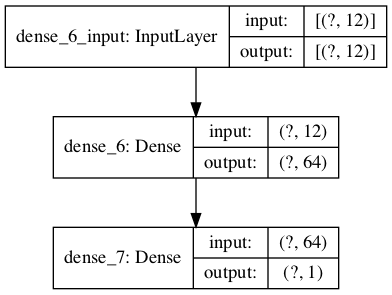

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score

seed = 7
np.random.seed(seed)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train, test in kfold.split(X, y):
    # use the model defined above
    model = modelA
    
    # compile the model
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    # fit the model to the data
    model.fit(X[train], y[train], epochs=3, verbose=1)
    
    # evaluate the model
    mse_value, mae_value = model.evaluate(X[test], y[test], verbose=0)
    
    print('loss: {:.4f}'.format(mse_value))
    print('MAE: {:.4f}'.format(mae_value))
    
    # predict values and calculate r2
    y_pred = model.predict(X[test])
    
    r2 = r2_score(y[test], y_pred)
    
    print('r2: {:.4f}'.format(r2))
    

keras.utils.plot_model(model, "./images/wine_A.png", show_shapes=True)

#### modelB: 

- input layer (12 attributes == 12 units)

- 1 hidden layer (128 units)

- output layer (one unit)

In [30]:
# construct another model
# two layers, units = 128

modelB= keras.models.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(12,)),
    keras.layers.Dense(1)
])

Epoch 1/3
163/163 [==============================] - 0s 608us/step - loss: 9.1754 - mae: 2.4497
Epoch 2/3
163/163 [==============================] - 0s 498us/step - loss: 1.1274 - mae: 0.8300
Epoch 3/3
163/163 [==============================] - 0s 454us/step - loss: 0.7354 - mae: 0.6697
loss: 0.7219
MAE: 0.6400
r2: 0.0562
Epoch 1/3
163/163 [==============================] - 0s 593us/step - loss: 0.6021 - mae: 0.6001
Epoch 2/3
163/163 [==============================] - 0s 449us/step - loss: 0.5425 - mae: 0.5710
Epoch 3/3
163/163 [==============================] - 0s 477us/step - loss: 0.5167 - mae: 0.5560
loss: 0.5039
MAE: 0.5537
r2: 0.3400
Epoch 1/3
163/163 [==============================] - 0s 600us/step - loss: 0.5002 - mae: 0.5493
Epoch 2/3
163/163 [==============================] - 0s 512us/step - loss: 0.4838 - mae: 0.5412
Epoch 3/3
163/163 [==============================] - 0s 533us/step - loss: 0.4780 - mae: 0.5389
loss: 0.4963
MAE: 0.5438
r2: 0.3499
Epoch 1/3
163/163 [=========

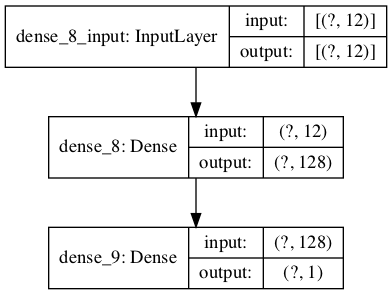

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score

seed = 7
np.random.seed(seed)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train, test in kfold.split(X, y):
    model = modelB
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    model.fit(X[train], y[train], epochs=3, verbose=1)
    
    mse_value, mae_value = model.evaluate(X[test], y[test], verbose=0)
    print('loss: {:.4f}'.format(mse_value))
    print('MAE: {:.4f}'.format(mae_value))
    
    y_pred = model.predict(X[test])
    
    r2 = r2_score(y[test], y_pred)
    
    print('r2: {:.4f}'.format(r2))
    

keras.utils.plot_model(model, "./images/wine_B.png", show_shapes=True)    

#### modelC: 

- input layer (12 attributes == 12 units)

- 2 hidden layer (64 units, 64 units)

- output layer (one unit)

In [32]:
# construct a model

modelC = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(12,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

Epoch 1/3
163/163 [==============================] - 0s 635us/step - loss: 4.1872 - mae: 1.4784
Epoch 2/3
163/163 [==============================] - 0s 486us/step - loss: 0.8879 - mae: 0.7311
Epoch 3/3
163/163 [==============================] - 0s 470us/step - loss: 0.6298 - mae: 0.6169
loss: 0.6708
MAE: 0.6233
r2: 0.1230
Epoch 1/3
163/163 [==============================] - 0s 700us/step - loss: 0.5579 - mae: 0.5810
Epoch 2/3
163/163 [==============================] - 0s 552us/step - loss: 0.5249 - mae: 0.5658
Epoch 3/3
163/163 [==============================] - 0s 598us/step - loss: 0.5044 - mae: 0.5515
loss: 0.5171
MAE: 0.5646
r2: 0.3227
Epoch 1/3
163/163 [==============================] - 0s 634us/step - loss: 0.5023 - mae: 0.5503
Epoch 2/3
163/163 [==============================] - 0s 561us/step - loss: 0.4921 - mae: 0.5468
Epoch 3/3
163/163 [==============================] - 0s 560us/step - loss: 0.4790 - mae: 0.5389
loss: 0.5852
MAE: 0.5963
r2: 0.2335
Epoch 1/3
163/163 [=========

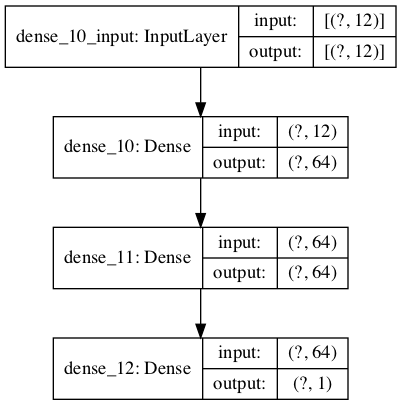

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score

seed = 7
np.random.seed(seed)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train, test in kfold.split(X, y):
    model = modelC
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    model.fit(X[train], y[train], epochs=3, verbose=1)
    
    mse_value, mae_value = model.evaluate(X[test], y[test], verbose=0)
    print('loss: {:.4f}'.format(mse_value))
    print('MAE: {:.4f}'.format(mae_value))
    
    y_pred = model.predict(X[test])
    
    r2 = r2_score(y[test], y_pred)
    
    print('r2: {:.4f}'.format(r2))
    
keras.utils.plot_model(model, "./images/wine_A.png", show_shapes=True)

### Optimization of parameters

#### RMPprop

Import RMSprop from keras.models and adjust the learning rate lr.

In [34]:
rmsprop = keras.optimizers.RMSprop(lr=0.0001)

model.compile(optimizer=rmsprop, loss='mse', metrics=['mae'])

#### Stochastic Gradient Descent (SGD)


In [35]:
sgd=keras.optimizers.SGD(lr=0.1)
model.compile(optimizer=sgd, loss='mse', metrics=['mae'])

## Check out Keras for more details.

https://keras.io